## Notebook to create a regional rainfall-runoff model using an LSTM network for CAMELS CH Dataset

*Transformer architecture;*
*Only 229 catchments belonging to CH from CAMELS CH*

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models, but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity. The model generated in this code makes use of the CAMELS CH Datset [2]

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**Adaptations:**
- Sanika Baste (sanika.baste@kit.edu)

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

[2]: Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data, 15, 5755–5784, https://doi.org/10.5194/essd-15-5755-2023, 2023.

In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsch import CAMELS_CH

# Import model
# from customlstm_original_softplus import customLSTM

# ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Part 1. Initialize information

In [2]:
# Define experiment name
experiment_name = "LSTM_CAMELS_CH_transformers_we_229CH"

# paths to access the information
path_entities = "../../data/basin_id/basins_camels_ch_229_onlyCH.txt"
path_data = "../../data/CAMELS_CH"

# dynamic forcings and target
dynamic_input = ['precipitation(mm/d)', 'temperature_min(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)', 'swe(mm)']
target = ['discharge_spec(mm/d)']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'slope_mean',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity',
                'conductivity',
                'glac_area',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1995-10-01','2005-09-30']
validation_period = ['2005-10-01','2010-09-30']
testing_period = ['2010-10-01','2015-09-30']

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_validation":512,
    "batch_size_testing":(pd.to_datetime(testing_period[1])-pd.to_datetime(testing_period[0])).days+1,
    "no_of_epochs": 30,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 10,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 1,
    "validate_n_random_basins": -1
    }

transformer_hyperparameters = {
                                "transformer_positional_encoding_type":'sum',
                                "transformer_positional_dropout": 0.0,
                                "seq_length": model_hyper_parameters["seq_length"],
                                "transformer_nheads": 4,
                                "transformer_dim_feedforward": 32,
                                "transformer_dropout": 0,
                                "transformer_nlayers": 4,
                                "output_dropout": model_hyper_parameters["drop_out_rate"]
                                }

dynamic_embedding_spec = {"type": "fc",
                            "hiddens": [64],
                            "activation": "linear",
                            "dropout": 0.0}
static_embedding_spec = {"type": "fc",
                            "hiddens": [64],
                            "activation": "linear",
                            "dropout": 0.0}

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 17

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [3]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CAMELS_CH_transformers_we_229CH' created successfully.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [5]:
# Dataset training
training_dataset = CAMELS_CH(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [6]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  1382
x_lstm: torch.Size([256, 365, 27]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [7]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

Part 4.0: Transformer

In [8]:
from typing import List

import numpy as np
import torch
import torch.nn as nn


class FC(nn.Module):
    """Auxiliary class to build (multi-layer) fully-connected networks.

    This class is used to build fully-connected embedding networks for static and/or dynamic input data.
    Use the config argument `statics/dynamics_embedding` to specify the architecture of the embedding network. See the
    `InputLayer` class on how to specify the exact embedding architecture.

    Parameters
    ----------
    input_size : int
        Number of input features.
    hidden_sizes : List[int]
        Size of the hidden and output layers.
    activation : str, optional
        Activation function for intermediate layers, default tanh.
    dropout : float, optional
        Dropout rate in intermediate layers.
    """

    def __init__(self, input_size: int, hidden_sizes: List[int], activation: str = 'tanh', dropout: float = 0.0):
        super(FC, self).__init__()

        if len(hidden_sizes) == 0:
            raise ValueError('hidden_sizes must at least have one entry to create a fully-connected net.')

        self.output_size = hidden_sizes[-1]
        hidden_sizes = hidden_sizes[:-1]

        activation = self._get_activation(activation)

        # create network
        layers = []
        if hidden_sizes:
            for i, hidden_size in enumerate(hidden_sizes):
                if i == 0:
                    layers.append(nn.Linear(input_size, hidden_size))
                else:
                    layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))

                layers.append(activation)
                layers.append(nn.Dropout(p=dropout))

            layers.append(nn.Linear(hidden_size, self.output_size))
        else:
            layers.append(nn.Linear(input_size, self.output_size))

        self.net = nn.Sequential(*layers)
        self._reset_parameters()

    def _get_activation(self, name: str) -> nn.Module:
        if name.lower() == "tanh":
            activation = nn.Tanh()
        elif name.lower() == "sigmoid":
            activation = nn.Sigmoid()
        elif name.lower() == "relu":
            activation = nn.ReLU()
        elif name.lower() == "linear":
            activation = nn.Identity()
        else:
            raise NotImplementedError(f"{name} currently not supported as activation in this class")
        return activation

    def _reset_parameters(self):
        """Special initialization of certain model weights."""
        for layer in self.net:
            if isinstance(layer, nn.modules.linear.Linear):
                n_in = layer.weight.shape[1]
                gain = np.sqrt(3 / n_in)
                nn.init.uniform_(layer.weight, -gain, gain)
                nn.init.constant_(layer.bias, val=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass on the FC model.

        Parameters
        ----------
        x : torch.Tensor
            Input data of shape [any, any, input size]

        Returns
        -------
        torch.Tensor
            Embedded inputs of shape [any, any, output_size], where 'output_size' is the size of the last network layer.
        """
        return self.net(x)

In [9]:
import logging
from typing import Dict, Optional, Union, Tuple

import torch
import torch.nn as nn

# from neuralhydrology.modelzoo.fc import FC
# from neuralhydrology.utils.config import Config

LOGGER = logging.getLogger(__name__)

_EMBEDDING_TYPES = ['full_model', 'hindcast', 'forecast']

class InputLayer(nn.Module):
    """Input layer to preprocess static and dynamic inputs.

    This module provides optional embedding of dynamic and static inputs. If ``dynamic_embeddings`` or
    ``static_embeddings`` are specified as dictionaries in the config, a fully-connected embedding network will be
    prepended to the timeseries model. The dictionaries have the following keys:

    - ``type`` (default 'fc'): Type of the embedding net. Currently, only 'fc' for fully-connected net is supported.
    - ``hiddens``: List of integers that define the number of neurons per layer in the fully connected network.
      The last number is the number of output neurons. Must have at least length one.
    - ``activation`` (default 'tanh'): activation function of the network. Supported values are 'tanh', 'sigmoid',
      'linear'. The activation function is not applied to the output neurons, which always have a linear activation
      function. An activation function for the output neurons has to be applied in the main model class.
    - ``dropout`` (default 0.0): Dropout rate applied to the embedding network.

    Note that this module does not support multi-frequency runs.

    Parameters
    ----------
    cfg : Config
        The run configuration
    """

    def __init__(self,
                 # cfg: Config,
                 dynamic_inputs: List,
                 static_attributes: List,
                 dynamic_embedding_spec: Dict,
                 static_embedding_spec: Dict,
                 embedding_type: str = 'full_model'):
        super(InputLayer, self).__init__()

        if embedding_type not in _EMBEDDING_TYPES:
            raise ValueError(
                f'Embedding type {embedding_type} is not recognized. '
                f'Must be one of: {_EMBEDDING_TYPES}.'
            )
        self.embedding_type = embedding_type
        # if embedding_type == 'full_model':
        #     dynamic_inputs = cfg.dynamic_inputs
        # elif embedding_type == 'forecast':
        #     dynamic_inputs = cfg.forecast_inputs
        # elif embedding_type == 'hindcast':
        #     dynamic_inputs = cfg.hindcast_inputs
            
        if isinstance(dynamic_inputs, dict):
            frequencies = list(dynamic_inputs.keys())
            if len(frequencies) > 1:
                raise ValueError('InputLayer only supports single-frequency data')
            dynamics_input_size = len(dynamic_inputs[frequencies[0]])
        else:
            dynamics_input_size = len(dynamic_inputs)

        self._num_autoregression_inputs = 0
        # if cfg.autoregressive_inputs:
        #     self._num_autoregression_inputs = len(cfg.autoregressive_inputs)

        # statics_input_size = len(cfg.static_attributes + cfg.hydroatlas_attributes + cfg.evolving_attributes)
        statics_input_size = len(static_attributes)
        # if cfg.use_basin_id_encoding:
        #     statics_input_size += cfg.number_of_basins

        self.statics_embedding, self.statics_output_size = \
            self._get_embedding_net(embedding_spec=static_embedding_spec, input_size=statics_input_size, purpose='statics')
        self.dynamics_embedding, self.dynamics_output_size = \
            self._get_embedding_net(embedding_spec=dynamic_embedding_spec, input_size=dynamics_input_size, purpose='dynamics')

        # if cfg.statics_embedding is None:
        #     self.statics_embedding_p_dropout = 0.0  # if net has no statics dropout we treat is as zero
        # else:
        #     self.statics_embedding_p_dropout = cfg.statics_embedding['dropout']
        # if cfg.dynamics_embedding is None:
        #     self.dynamics_embedding_p_dropout = 0.0  # if net has no dynamics dropout we treat is as zero
        # else:
        #     self.dynamics_embedding_p_dropout = cfg.dynamics_embedding['dropout']
        self.statics_embedding_p_dropout = 0.0  # if net has no statics dropout we treat is as zero
        self.dynamics_embedding_p_dropout = 0.0  # if net has no dynamics dropout we treat is as zero

        self.output_size = self.dynamics_output_size + self.statics_output_size + self._num_autoregression_inputs
        # if cfg.head.lower() == "umal":
        #     self.output_size += 1

    @staticmethod
    def _get_embedding_net(embedding_spec: Optional[dict], input_size: int, purpose: str) -> Tuple[nn.Module, int]:
        """Get an embedding net following the passed specifications.

        If the `embedding_spec` is None, the returned embedding net will be the identity function.

        Parameters
        ----------
        embedding_spec : Optional[dict]
            Specification of the embedding net from the run configuration or None.
        input_size : int
            Size of the inputs into the embedding network.
        purpose : str
            Purpose of the embedding network, used for error messages.

        Returns
        -------
        Tuple[nn.Module, int]
            The embedding net and its output size.
        """
        if embedding_spec is None:
            return nn.Identity(), input_size

        if input_size == 0:
            raise ValueError(f'Cannot create {purpose} embedding layer with input size 0')

        emb_type = embedding_spec['type'].lower()
        if emb_type != 'fc':
            raise ValueError(f'{purpose} embedding type {emb_type} not supported.')

        hiddens = embedding_spec['hiddens']
        if len(hiddens) == 0:
            raise ValueError(f'{purpose} embedding "hiddens" must be a list of hidden sizes with at least one entry')

        dropout = embedding_spec['dropout']
        activation = embedding_spec['activation']

        emb_net = FC(input_size=input_size, hidden_sizes=hiddens, activation=activation, dropout=dropout)
        return emb_net, emb_net.output_size

    def forward(self, data: Dict[str, torch.Tensor], concatenate_output: bool = True) \
            -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Perform a forward pass on the input layer.

        Parameters
        ----------
        data : Dict[str, torch.Tensor]
            The input data.
        concatenate_output : bool, optional
            If True (default), the forward method will concatenate the static inputs to each dynamic time step.
            If False, the forward method will return a tuple of (dynamic, static) inputs.

        Returns
        -------
        Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
            If `concatenate_output` is True, a single tensor is returned. Else, a tuple with one tensor of dynamic
            inputs and one tensor of static inputs.
        """
        # transpose to [seq_length, batch_size, n_features]
        if self.embedding_type == 'full_model':
            data_type = 'x_lstm'
        elif self.embedding_type == 'forecast':
            data_type = 'x_f'
        elif self.embedding_type == 'hindcast':
            data_type = 'x_h'
        x_d_ = data['x_lstm'][:, :, 0:5]
        x_d = x_d_.transpose(0, 1)

        if 'x_s' in data and 'x_one_hot' in data:
            x_s = torch.cat([data['x_s'], data['x_one_hot']], dim=-1)
        elif 'x_s' in data:
            x_s = data['x_s']
        elif 'x_one_hot' in data:
            x_s = data['x_one_hot']
        else:
            x_s = data['x_lstm'][:, 1, -22:]

        # Don't run autoregressive inputs through the embedding layer. This does not work with NaN's
        if self._num_autoregression_inputs > 0:
            dynamics_out = self.dynamics_embedding(x_d[:, :, :-self._num_autoregression_inputs])
        else:
            dynamics_out = self.dynamics_embedding(x_d)

        statics_out = None
        if x_s is not None:
            statics_out = self.statics_embedding(x_s)

        if not concatenate_output:
            ret_val = dynamics_out, statics_out
        else:
            if statics_out is not None:
                statics_out = statics_out.unsqueeze(0).repeat(dynamics_out.shape[0], 1, 1)
                ret_val = torch.cat([dynamics_out, statics_out], dim=-1)
            else:
                ret_val = dynamics_out
            
            # Append autoregressive inputs to the end of the output.
            if self._num_autoregression_inputs:
                ret_val = torch.cat([ret_val, x_d[:, :, -self._num_autoregression_inputs:]], dim=-1)

        return ret_val

    def __getitem__(self, item: str) -> nn.Module:
        # required for dict-like access when freezing submodules' gradients in fine-tuning
        if item == "statics_embedding":
            return self.statics_embedding
        elif item == "dynamics_embedding":
            return self.dynamics_embedding
        else:
            raise KeyError(f"Cannot access {item} on InputLayer")

In [10]:
import logging
import math
from typing import Dict

import numpy as np
import torch
import torch.nn as nn

# from neuralhydrology.modelzoo.inputlayer import InputLayer
# from neuralhydrology.modelzoo.head import get_head
# from neuralhydrology.modelzoo.basemodel import BaseModel
# from neuralhydrology.utils.config import Config

# LOGGER = logging.getLogger(__name__)


class Transformer(nn.Module):
    """Transformer model class, which relies on PyTorch's TransformerEncoder class.

    This class implements the encoder of a transformer network which can be used for regression.
    Unless the number of inputs is divisible by the number of transformer heads (``transformer_nheads``), it is
    necessary to use an embedding network that guarantees this. To achieve this, use ``statics/dynamics_embedding``,
    so the static/dynamic inputs will be passed through embedding networks before being concatenated. The embedding
    network will then map the static and dynamic features to size ``statics/dynamics_embedding['hiddens'][-1]``, so the
    total embedding size will be the sum of these values.
    The model configuration is specified in the config file using the following options:

    * ``transformer_positional_encoding_type``: choices to "sum" or "concatenate" positional encoding to other model
      inputs.
    * ``transformer_positional_dropout``: fraction of dropout applied to the positional encoding.
    * ``seq_length``: integer number of timesteps to treat in the input sequence.
    * ``transformer_nheads``: number of self-attention heads.
    * ``transformer_dim_feedforward``: dimension of the feed-forward networks between self-attention heads.
    * ``transformer_dropout``: dropout in the feedforward networks between self-attention heads.
    * ``transformer_nlayers``: number of stacked self-attention + feedforward layers.

    Parameters
    ----------
    cfg : Config
        The run configuration.
    """
    # specify submodules of the model that can later be used for finetuning. Names must match class attributes
    module_parts = ['embedding_net', 'encoder', 'head']

    def __init__(self,
                 #cfg: Config,
                transformer_positional_encoding_type: str,
                transformer_positional_dropout: float,
                seq_length: int,
                transformer_nheads: int,
                transformer_dim_feedforward: int,
                transformer_dropout: float,
                transformer_nlayers: int,
                output_dropout: float,
                dynamic_inputs: List,
                static_attributes: List,
                dynamic_embedding_spec: Dict,
                static_embedding_spec: Dict):
        super(Transformer, self).__init__()

        # embedding net before transformer
        self.embedding_net = InputLayer(dynamic_inputs,
                                        static_attributes,
                                        dynamic_embedding_spec,
                                        static_embedding_spec,
                                        embedding_type = 'full_model')

        # ensure that the number of inputs into the self-attention layer is divisible by the number of heads
        if self.embedding_net.output_size % transformer_nheads != 0:
            raise ValueError("Embedding dimension must be divisible by number of transformer heads. "
                             "Use statics_embedding/dynamics_embedding and embedding_hiddens to specify the embedding.")

        self._sqrt_embedding_dim = math.sqrt(self.embedding_net.output_size)

        # positional encoder
        self._positional_encoding_type = transformer_positional_encoding_type
        if self._positional_encoding_type.lower() == 'concatenate':
            encoder_dim = self.embedding_net.output_size * 2
        elif self._positional_encoding_type.lower() == 'sum':
            encoder_dim = self.embedding_net.output_size
        else:
            raise RuntimeError(f"Unrecognized positional encoding type: {self._positional_encoding_type}")
        self.positional_encoder = _PositionalEncoding(embedding_dim=self.embedding_net.output_size,
                                                      dropout=transformer_positional_dropout,
                                                      position_type=transformer_positional_encoding_type,
                                                      max_len=seq_length)

        # positional mask
        self._mask = None

        # encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=encoder_dim,
                                                    nhead=transformer_nheads,
                                                    dim_feedforward=transformer_dim_feedforward,
                                                    dropout=transformer_dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layers,
                                             num_layers=transformer_nlayers,
                                             norm=None)

        # head (instead of a decoder)
        self.dropout = nn.Dropout(p=output_dropout)
        # self.head = get_head(cfg=cfg, n_in=encoder_dim, n_out=self.output_size)
        self.linear = nn.Linear(in_features = encoder_dim, out_features=1)

        # init weights and biases
        self._reset_parameters()

    def _reset_parameters(self):
        # this initialization strategy was tested empirically but may not be the universally best strategy in all cases.
        initrange = 0.1
        for layer in self.encoder.layers:
            layer.linear1.weight.data.uniform_(-initrange, initrange)
            layer.linear1.bias.data.zero_()
            layer.linear2.weight.data.uniform_(-initrange, initrange)
            layer.linear2.bias.data.zero_()

    def forward(self, data: Dict[str, torch.Tensor], device) -> Dict[str, torch.Tensor]:
        """Perform a forward pass on a transformer model without decoder.

        Parameters
        ----------
        data : Dict[str, torch.Tensor]
            Dictionary, containing input features as key-value pairs.

        Returns
        -------
        Dict[str, torch.Tensor]
            Model outputs and intermediate states as a dictionary.
                - `y_hat`: model predictions of shape [batch size, sequence length, number of target variables].
        """
        # pass dynamic and static inputs through embedding layers, then concatenate them
        data['x_lstm'] = data['x_lstm'].to(device)
        x_d = self.embedding_net(data)

        positional_encoding = self.positional_encoder(x_d * self._sqrt_embedding_dim)

        # mask out future values
        if self._mask is None or self._mask.size(0) != len(x_d):
            self._mask = torch.triu(x_d.new_full((len(x_d), len(x_d)), fill_value=float('-inf')), diagonal=1)

        # encoding
        output = self.encoder(positional_encoding, self._mask)

        # prediction
        y_hat_sequence = self.linear(self.dropout(output.transpose(0, 1)))

        # returning output as a dictionary
        pred = {"output": output,
            "y_hat_sequence": y_hat_sequence,
            "y_hat": y_hat_sequence[:, -1, :],
            "embedding": x_d,
            "positional_encoding": positional_encoding}

        return pred


class _PositionalEncoding(nn.Module):
    """Class to create a positional encoding vector for timeseries inputs to a model without an explicit time dimension.

    This class implements a sin/cos type embedding vector with a specified maximum length. Adapted from the PyTorch
    example here: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Parameters
    ----------
    embedding_dim : int
        Dimension of the model input, which is typically output of an embedding layer.
    dropout : float
        Dropout rate [0, 1) applied to the embedding vector.
    max_len : int, optional
        Maximum length of positional encoding. This must be larger than the largest sequence length in the sample.
    """

    def __init__(self, embedding_dim, position_type, dropout, max_len=5000):
        super(_PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, int(np.ceil(embedding_dim / 2) * 2))
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(max_len * 2) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe[:, :embedding_dim].unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

        if position_type.lower() == 'concatenate':
            self._concatenate = True
        elif position_type.lower() == 'sum':
            self._concatenate = False
        else:
            raise RuntimeError(f"Unrecognized positional encoding type: {position_type}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass for positional encoding. Either concatenates or adds positional encoding to encoder input data.

        Parameters
        ----------
        x : torch.Tensor
            Dimension is ``[sequence length, batch size, embedding output dimension]``.
            Data that is to be the input to a transformer encoder after including positional encoding.
            Typically this will be output from an embedding layer.

        Returns
        -------
        torch.Tensor
            Dimension is ``[sequence length, batch size, encoder input dimension]``.
            The encoder input dimension is either equal to the embedding output dimension (if ``position_type == sum``)
            or twice the embedding output dimension (if ``position_type == concatenate``).
            Encoder input augmented with positional encoding.

        """
        if self._concatenate:
            x = torch.cat((x, self.pe[:x.size(0), :].repeat(1, x.size(1), 1)), 2)
        else:
            x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Part 4. Train LSTM

In [12]:
#### construct model
set_random_seed(seed=seed)
transformer_model = Transformer(transformer_positional_encoding_type='sum',
                transformer_positional_dropout= 0,
                seq_length= 365,
                transformer_nheads= 4,
                transformer_dim_feedforward= 32,
                transformer_dropout= 0,
                transformer_nlayers= 4,
                output_dropout= 0.4,
                dynamic_inputs= dynamic_input,
                static_attributes= static_input,
                dynamic_embedding_spec= dynamic_embedding_spec,
                static_embedding_spec= static_embedding_spec).to(device)

# in case of training a previously trained model further
# path_pretrained = "../results/LSTM_CAMELS_CH_transformers_we_229CH"
# transformer_model.load_state_dict(torch.load(path_pretrained + "/epoch_21", map_location=device))

# optimizer
optimizer = torch.optim.Adam(transformer_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
# lstm_model.cell.b_hh.data[model_hyper_parameters["hidden_size"]:2 * model_hyper_parameters["hidden_size"]]=\
#     model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    transformer_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = transformer_model(sample, device) # forward call
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        
        loss.backward() # backpropagates
        optimizer.step() # update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        transformer_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_validation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = transformer_model(sample, device)
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(transformer_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

Epoch: 22 | Loss training: 0.009 | NSE validation: 0.809 | Epoch time: 285.4  s | LR:0.00025 
Epoch: 23 | Loss training: 0.009 | NSE validation: 0.820 | Epoch time: 279.7  s | LR:0.00025 
Epoch: 24 | Loss training: 0.009 | NSE validation: 0.808 | Epoch time: 280.2  s | LR:0.00025 
Epoch: 25 | Loss training: 0.009 | NSE validation: 0.826 | Epoch time: 279.9  s | LR:0.00025 
Epoch: 26 | Loss training: 0.008 | NSE validation: 0.829 | Epoch time: 279.8  s | LR:0.00025 
Epoch: 27 | Loss training: 0.009 | NSE validation: 0.827 | Epoch time: 279.9  s | LR:0.00025 
Epoch: 28 | Loss training: 0.008 | NSE validation: 0.830 | Epoch time: 280.1  s | LR:0.00025 
Epoch: 29 | Loss training: 0.008 | NSE validation: 0.822 | Epoch time: 279.9  s | LR:0.00025 
Epoch: 30 | Loss training: 0.008 | NSE validation: 0.813 | Epoch time: 279.5  s | LR:0.00025 
Total training time: 2524.5  s


Part 5. Test LSTM

In [12]:
# In case I already trained an LSTM I can re-construct the model
transformer_model = Transformer(transformer_positional_encoding_type='sum',
                transformer_positional_dropout= 0,
                seq_length= 365,
                transformer_nheads= 4,
                transformer_dim_feedforward= 32,
                transformer_dropout= 0,
                transformer_nlayers= 4,
                output_dropout= 0.4,
                dynamic_inputs= dynamic_input,
                static_attributes= static_input,
                dynamic_embedding_spec= dynamic_embedding_spec,
                static_embedding_spec= static_embedding_spec).to(device)
transformer_model.load_state_dict(torch.load(path_save_folder + "/epoch_28", map_location=device))

/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [77]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
# entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
entities_ids = ['2346', '2303', '2494']
testing_dataset = {}
seq_length = model_hyper_parameters["seq_length"]-1
idx_to_change = [512, 519]

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    dataset.sequence_data[entity]['x_d'][idx_to_change[0]+seq_length:idx_to_change[1]+seq_length, 0] = 20000
    # dataset.sequence_data[entity]['x_s'][:] = 0
    testing_dataset[entity]= dataset

In [78]:
transformer_model.eval()
inspect_results_states = {}
inspect_results = {}
create_folder(folder_path=path_save_folder+"/inspect_results_states")

with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_testing"], 
                            shuffle = False, 
                            drop_last = False) 

        df_ts = pd.DataFrame()
        inspectmodel_output = []

        for sample in loader:
            pred  = transformer_model(sample, device) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            _output = {"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                               "y_hat": pred["y_hat"].flatten().cpu().detach(),
                                "y_sim": y_sim.flatten().cpu().detach()}

            inspectmodel_output.append(_output)

            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                               "y_hat": pred["y_hat"].flatten().cpu().detach(),
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))
            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        inspect_results_states[basin] = inspectmodel_output
        inspect_results[basin] = df_ts

        # Save results as a pickle file
        # with open(path_save_folder+"/inspect_results_states/"+str(basin)+".pickle", "wb") as f_:
        #    pickle.dump(inspectmodel_output, f_)
            
        del inspectmodel_output, df_ts
        print('Testing using CustomLSTM complete for ' + str(basin))

# Save results as a pickle file
with open(path_save_folder+"/inspect_results.pickle", "wb") as f:
    pickle.dump(inspect_results, f)

Folder '../results/LSTM_CAMELS_CH_transformers_we_229CH/inspect_results_states' already exists.
Testing using CustomLSTM complete for 2346
Testing using CustomLSTM complete for 2303
Testing using CustomLSTM complete for 2494


Part 6. Initial analysis

In [79]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [80]:
# Loss testing
loss_testing = nse(df_results=inspect_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE_transformer_we.csv", index=True, header=True)

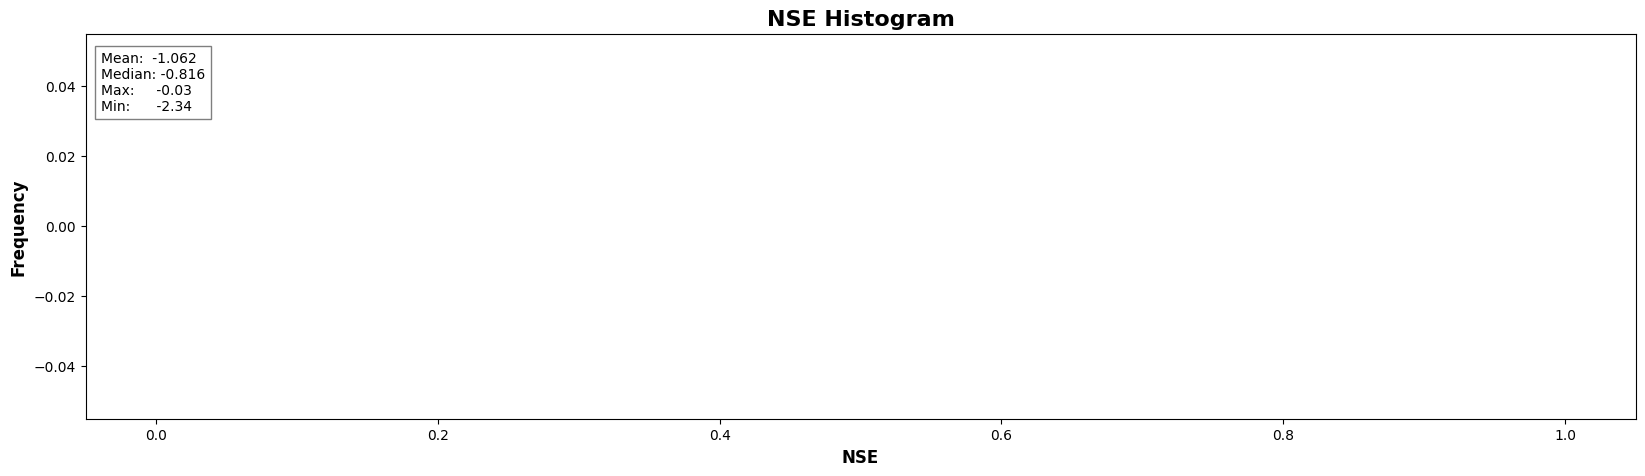

In [81]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

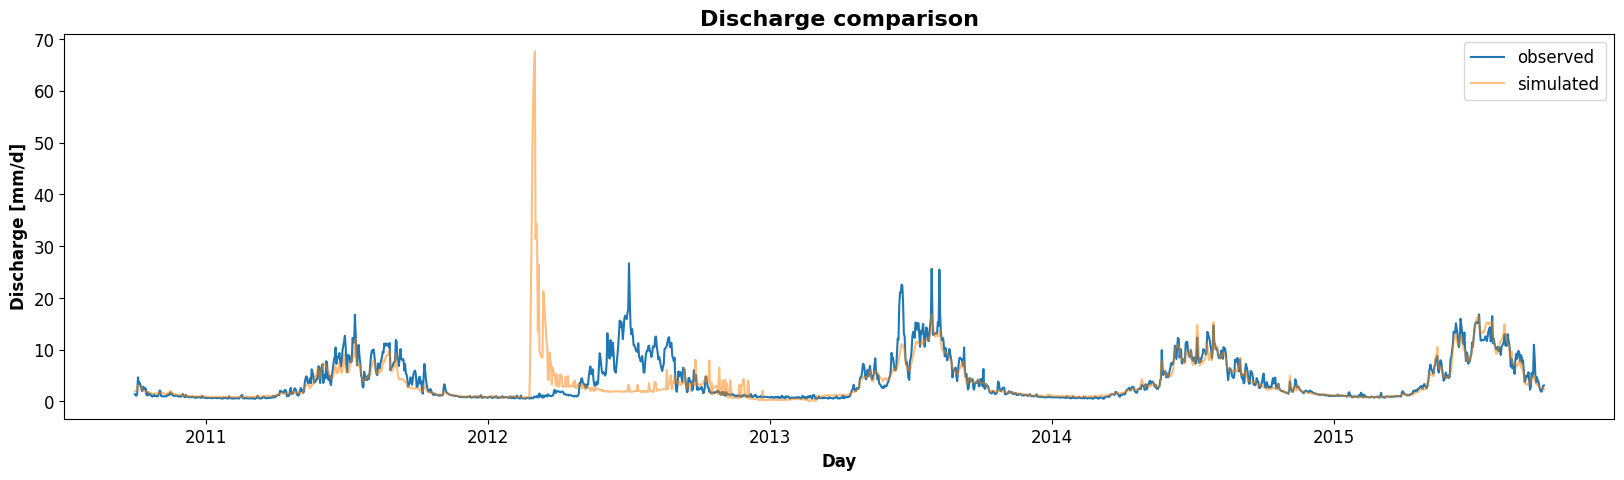

In [82]:
# Plot simulated and observed discharges
basin_to_analyze = "2346"

plt.plot(inspect_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(inspect_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)

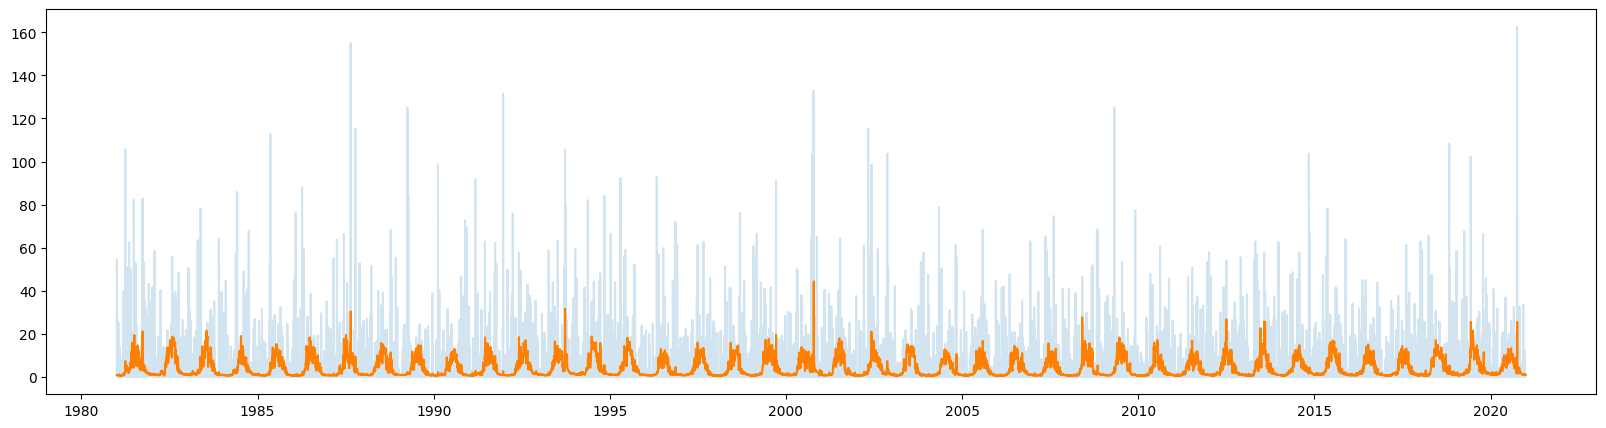

In [69]:
from pathlib import Path
path_timeseries_obs = Path(path_data) / 'timeseries' / 'observation_based' / f'CAMELS_CH_obs_based_{basin_to_analyze}.csv'
# load time series
df_obs = pd.read_csv(path_timeseries_obs)
df_obs = df_obs.set_index('date')
df_obs.index = pd.to_datetime(df_obs.index, format="%Y-%m-%d")

plt.plot(df_obs["precipitation(mm/d)"], label="precipitation", alpha=0.2, color=color_palette["observed"])
plt.plot(df_obs["discharge_spec(mm/d)"], label="discharge", color=color_palette["simulated"])
plt.show()

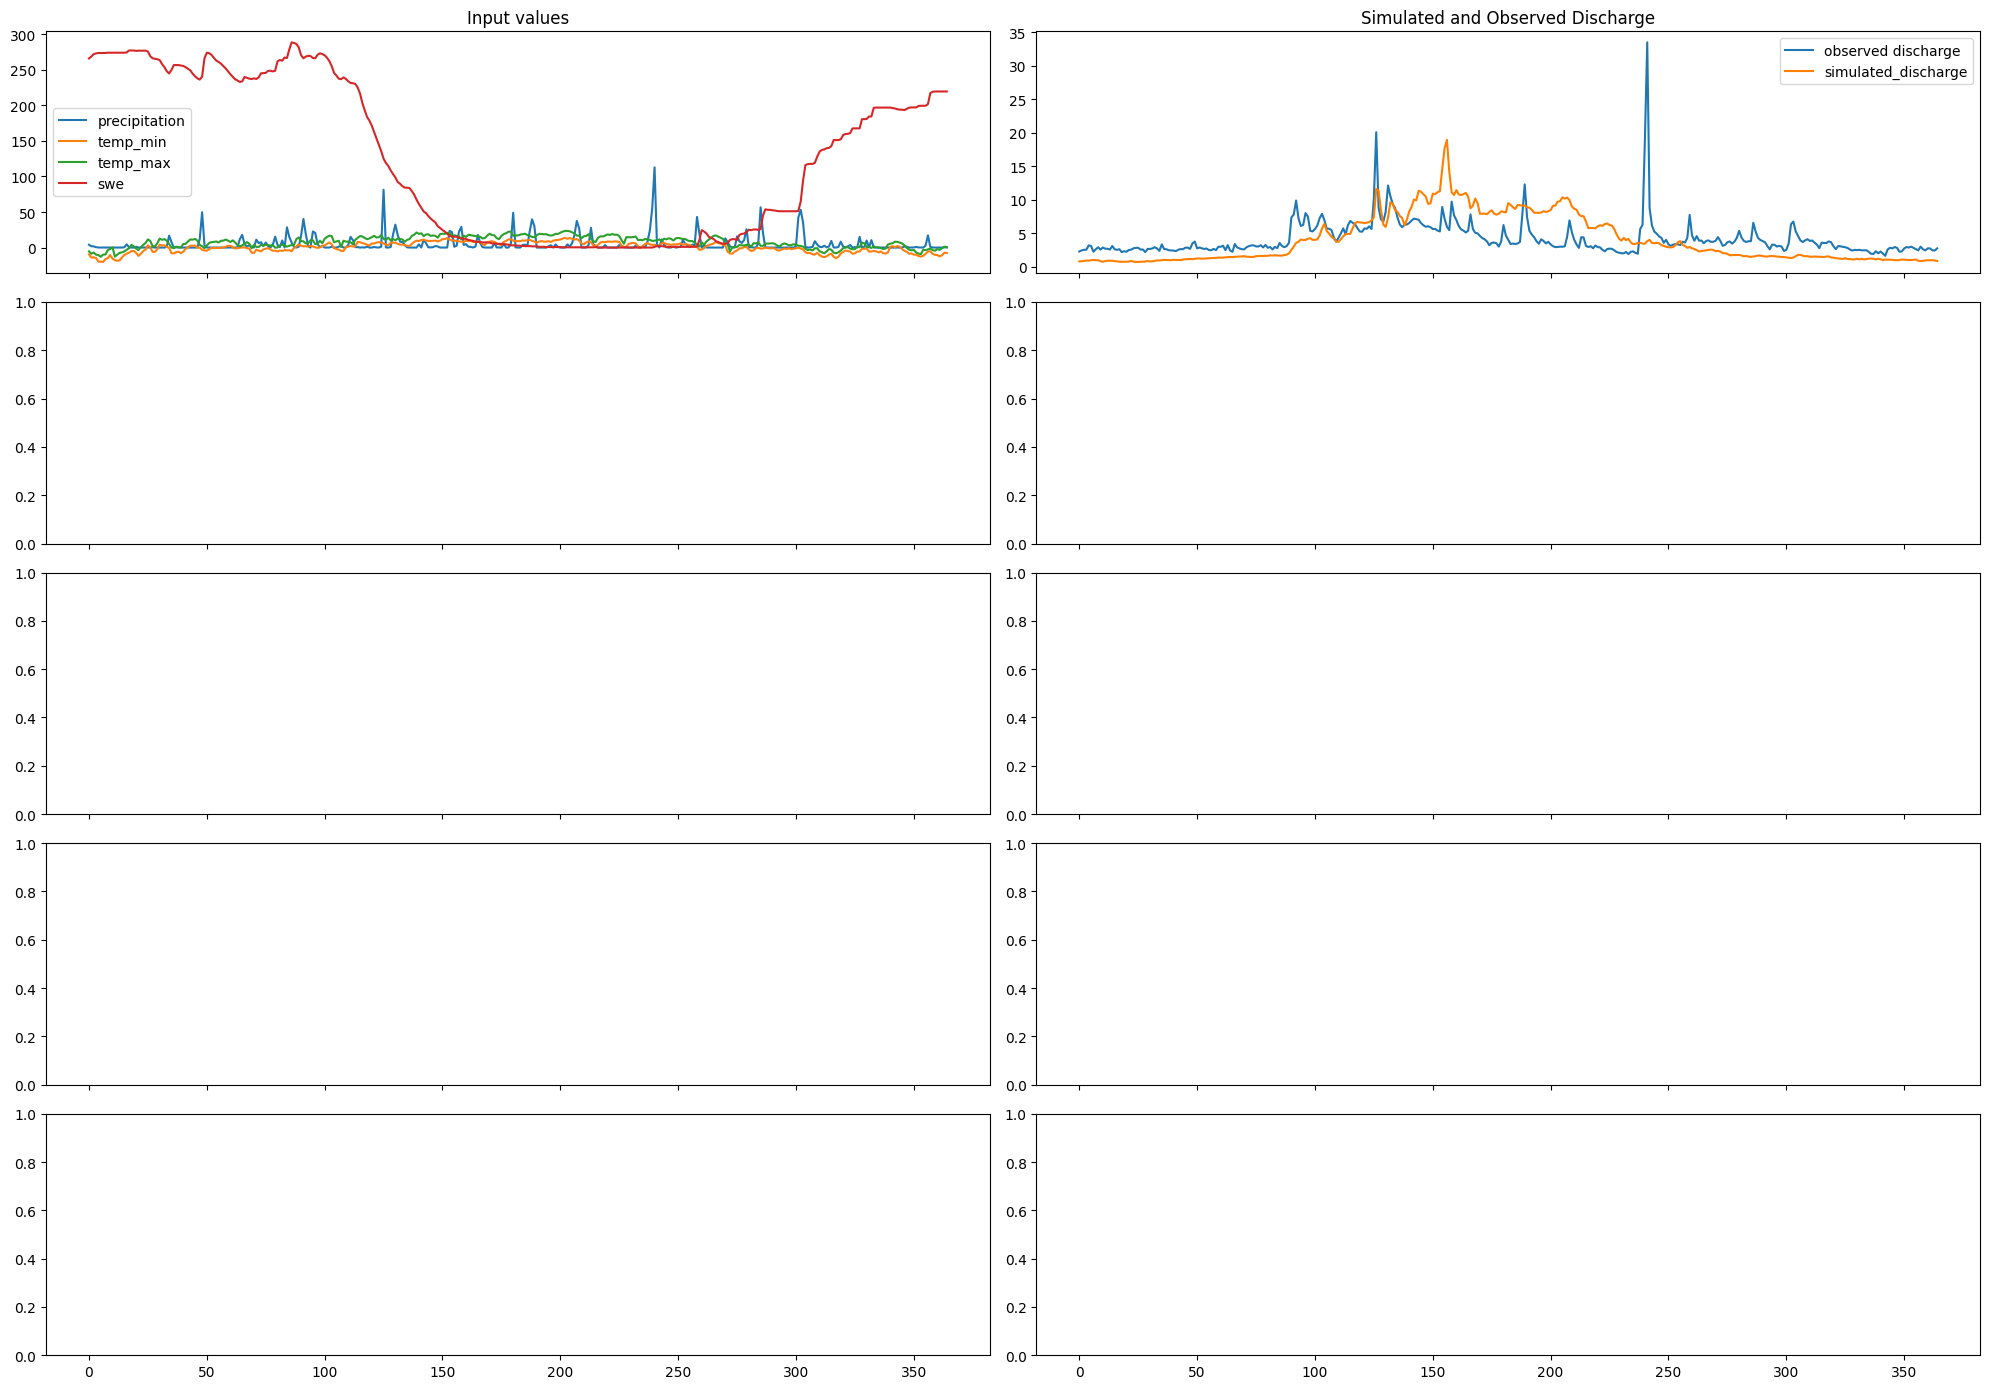

In [70]:
inspectmodel_states = inspect_results_states[basin_to_analyze]
# weights_linear, _ = lstm_model.linear.state_dict().items()

f, ax = plt.subplots(5, 2, figsize=(20, 14), sharex=True)
idx = 850
sl = model_hyper_parameters["seq_length"]

# observed input feature values
ax[0,0].set_title('Input values')
x_d_ = dataset.sequence_data[entity]['x_d'][:, 0:5]*dataset.scaler['x_d_std']+dataset.scaler['x_d_mean']
ax[0,0].plot(x_d_[idx:idx+sl, 0], label='precipitation')  
ax[0,0].plot(x_d_[idx:idx+sl, 1], label='temp_min')  
ax[0,0].plot(x_d_[idx:idx+sl, 2], label='temp_max')  
# ax[0,0].plot(x_d_[idx:idx+sl, 3], label='sun_dur')  
ax[0,0].plot(x_d_[idx:idx+sl, 4], label='swe')  
ax[0,0].legend()

ax[0,1].set_title('Simulated and Observed Discharge')
y_obs = dataset.sequence_data[entity]['y_obs'][:]
ax[0,1].plot(y_obs[idx:idx+sl], label='observed discharge', color=color_palette["observed"])
ax[0,1].plot(inspectmodel_states[0]['y_sim'][idx-sl:idx], label='simulated_discharge', color=color_palette["simulated"])
ax[0,1].legend()

# ax[1,0].set_title('Hidden state')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[1,0].plot(abs(inspectmodel_states[0]['h_n'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

# ax[1,1].set_title('Tanh Cell state')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[1,1].plot((np.tanh(inspectmodel_states[0]['c_n'][idx, :, l].numpy())), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

# ax[2,0].set_title('Difference Tanh Cell state')
# ax[2,0].plot(np.diff(np.tanh(inspectmodel_states[0]['c_n'][idx, :, :].numpy())))
# # ax[2,1].set_xlim([22, 35])

# ax[2,1].set_title('Cell state')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[2,1].plot(inspectmodel_states[0]['c_n'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))
# ax[2,1].set_ylim([-10, 10])

# ax[3,0].set_title('Output gate')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[3,0].plot(torch.sigmoid(inspectmodel_states[0]['o'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

# ax[3,1].set_title('Forget gate')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[3,1].plot(torch.sigmoid(inspectmodel_states[0]['f'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

# ax[4,0].set_title('Input gate')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[4,0].plot(torch.sigmoid(inspectmodel_states[0]['i'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

# ax[4,1].set_title('Cell input activation')
# for l in range(inspectmodel_states[0]['h_n'].shape[2]):
#     ax[4,1].plot(torch.tanh(inspectmodel_states[0]['g'][idx, :, l]).numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

plt.tight_layout()

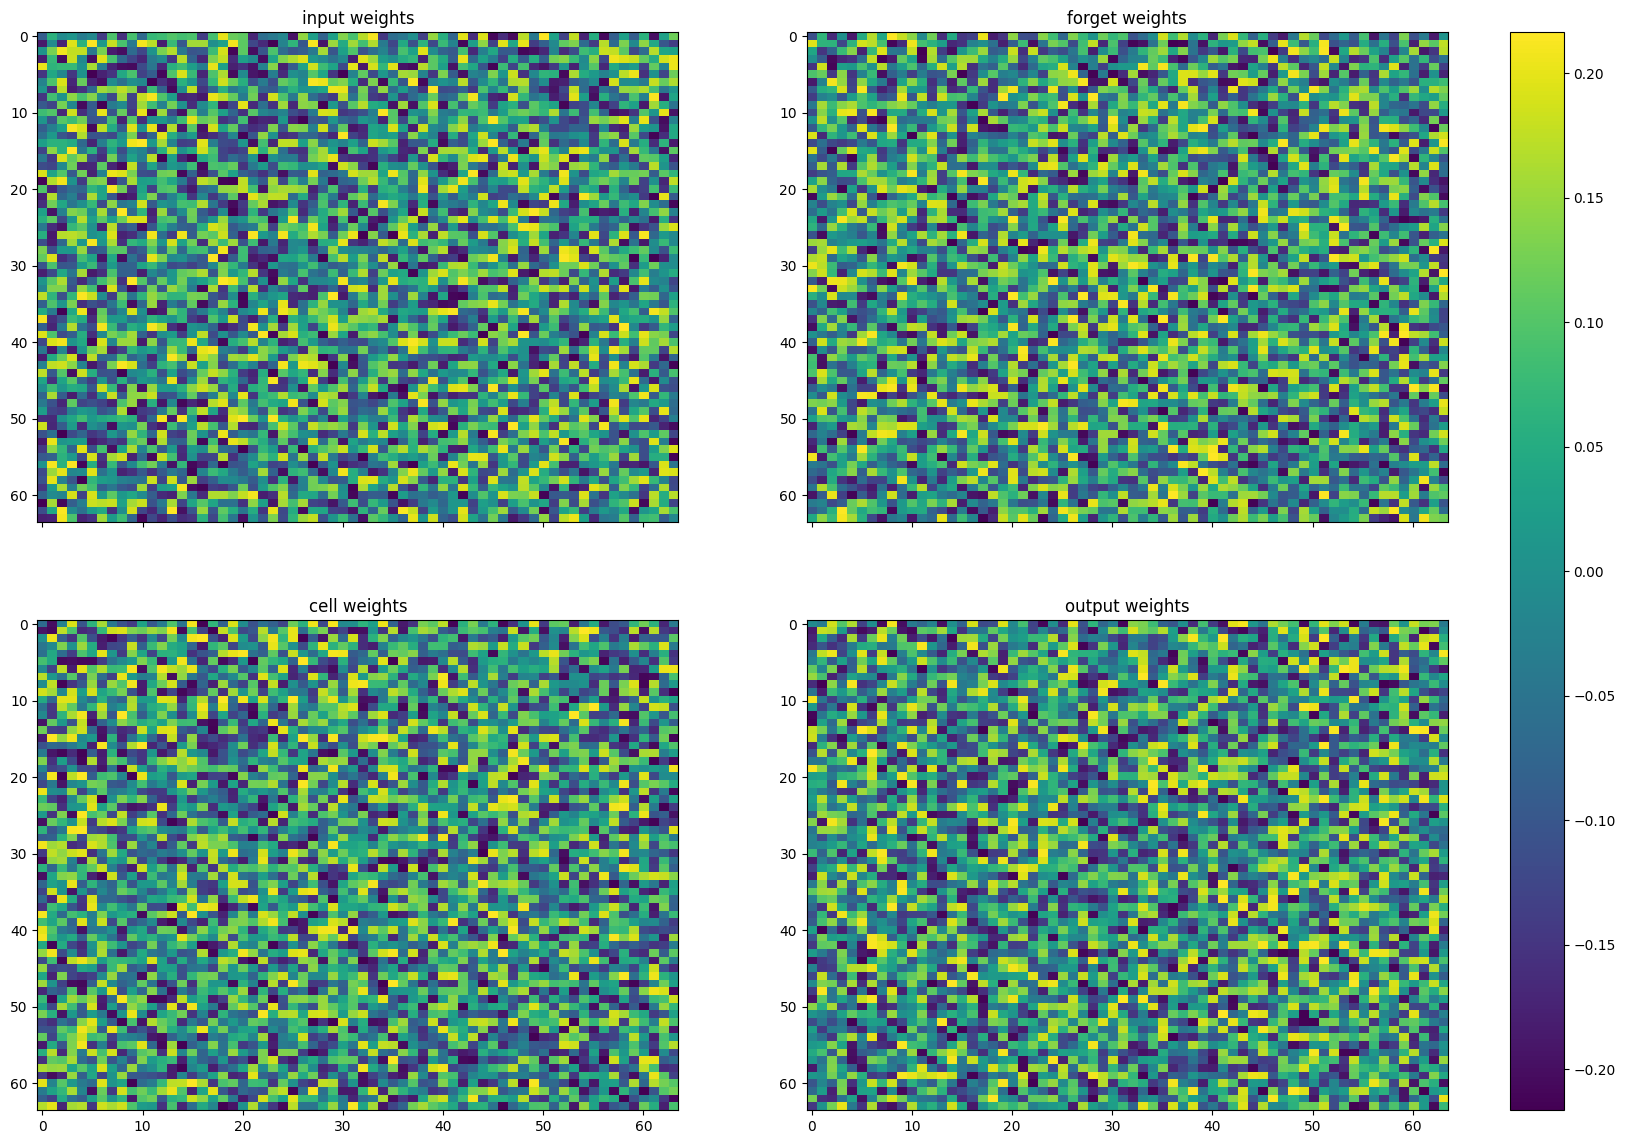

('weight', tensor([[-0.0060,  0.0029,  0.0378,  0.0003, -0.0036,  0.0006, -0.0010,  0.0002,
          0.0021, -0.0029, -0.0011,  0.0025,  0.0001,  0.0029, -0.0008,  0.0024,
         -0.0026, -0.0001,  0.0001, -0.0005,  0.0010, -0.0017,  0.0009,  0.0012,
         -0.0004, -0.0032,  0.0005, -0.0073, -0.0034,  0.0008, -0.0002, -0.0074,
         -0.0063, -0.0006,  0.0008,  0.0043,  0.0006,  0.0007,  0.0012, -0.0008,
         -0.0109, -0.0014, -0.0018, -0.0005,  0.0001,  0.0128,  0.0004, -0.0032,
         -0.0105,  0.0086,  0.0006, -0.0057, -0.0025,  0.0023,  0.0014,  0.0013,
         -0.0013,  0.0020,  0.0052, -0.0035, -0.0111,  0.0021,  0.0011,  0.0022]],
       device='cuda:0'))


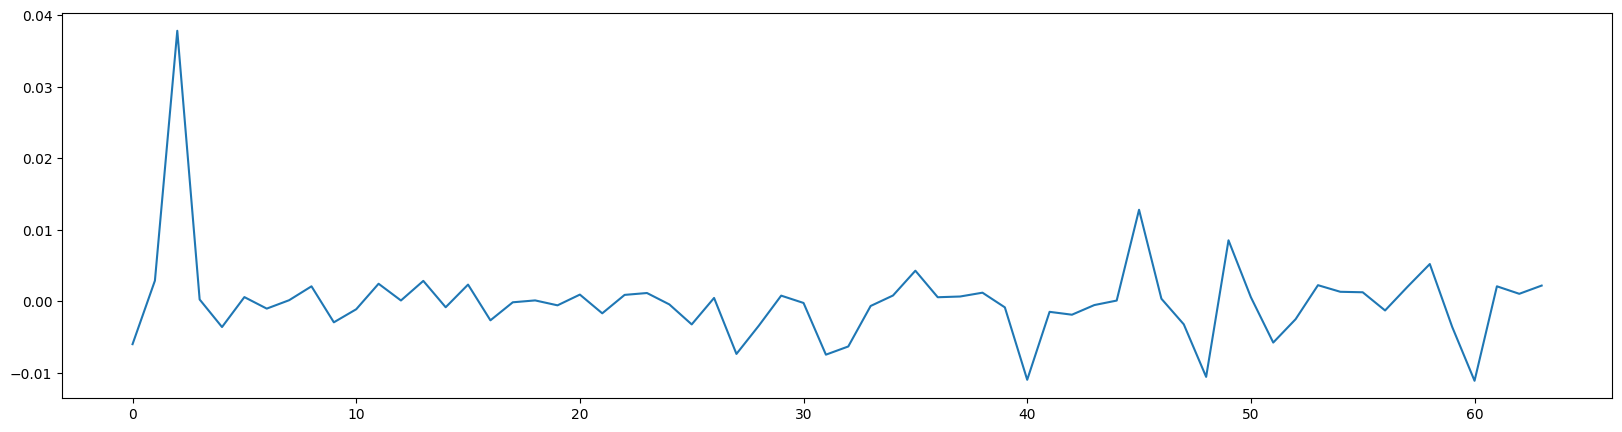

In [40]:
n_hs = model_hyper_parameters["hidden_size"]
w_ii, w_if, w_ig, w_io = torch.split(lstm_model_inspect.cell.w_hh, lstm_model_inspect.cell.w_ih.size(0) // 4, dim=0)

f, ax = plt.subplots(2, 2, figsize=(20, 14), sharex=True)

ax[0,0].set_title('input weights')
hm1 = ax[0,0].imshow(w_ii.detach().cpu().numpy(), aspect='auto')
ax[0,1].set_title('forget weights')
hm2 = ax[0,1].imshow(w_if.detach().cpu().numpy(), aspect='auto')
ax[1,0].set_title('cell weights')
hm3 = ax[1,0].imshow(w_ig.detach().cpu().numpy(), aspect='auto')
ax[1,1].set_title('output weights')
hm4 = ax[1,1].imshow(w_io.detach().cpu().numpy(), aspect='auto')

cbar = f.colorbar(hm1, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

plt.show()

print(weights_linear)
plt.plot(weights_linear[1][0].detach().cpu().numpy())
plt.show()

In [44]:
for weight in lstm_model.cell.parameters():
    print(weight.shape)

torch.Size([256, 64])
torch.Size([256, 27])
torch.Size([256])
torch.Size([256])
